<a href="https://colab.research.google.com/github/dataview26/freecodecamp-machine-learning-with-python-projects/blob/main/Copy_of_fcc_cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import os, zipfile, glob, shutil

print("TF:", tf.__version__)

TF: 2.19.0


In [ ]:
# Step A – Download dataset, set PATH, and prepare test/test images
import os, zipfile, shutil, tensorflow as tf

# URL for the cats and dogs dataset
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# Download the zip WITHOUT auto-extracting
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=False)

# Potential dataset locations
path_root    = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')  # ~/.keras/datasets/cats_and_dogs_filtered
path_content = '/content/cats_and_dogs_filtered'                                  # /content/cats_and_dogs_filtered (for Colab)

def has_data(base):
    """Returns True if base/validation/cats and base/validation/dogs both exist and have files."""
    vc = os.path.join(base, 'validation', 'cats')
    vd = os.path.join(base, 'validation', 'dogs')
    return os.path.isdir(vc) and os.path.isdir(vd) and len(os.listdir(vc)) > 0 and len(os.listdir(vd)) > 0

# Decide which path has data, otherwise extract to /content
if has_data(path_root):
    PATH = path_root
elif has_data(path_content):
    PATH = path_content
else:
    # Extract zip into /content if nothing found
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall('/content')
    PATH = path_content

print("PATH:", PATH)

# Define standard directories
train_dir      = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir       = os.path.join(PATH, 'test')     # new test dir that we'll populate

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

IMG_HEIGHT = 150
IMG_WIDTH  = 150
BATCH_SIZE = 32

print("train exists:", os.path.isdir(train_dir))
print("val exists:", os.path.isdir(validation_dir))
print("val cats count:", len(os.listdir(validation_cats_dir)))
print("val dogs count:", len(os.listdir(validation_dogs_dir)))

# Create the test/test subfolder (dummy class) and copy 25 cats + 25 dogs
test_subdir = os.path.join(test_dir, 'test') # single dummy class folder
os.makedirs(test_subdir, exist_ok=True)

# Clear old files
for f in os.listdir(test_subdir):
    os.remove(os.path.join(test_subdir, f))

cat_imgs = sorted([os.path.join(validation_cats_dir, f) for f in os.listdir(validation_cats_dir)])[:25]
dog_imgs = sorted([os.path.join(validation_dogs_dir, f) for f in os.listdir(validation_dogs_dir)])[:25]

for img in cat_imgs + dog_imgs: shutil.copy(img, test_subdir)

print("test exists:", os.path.isdir(test_dir))
print("test count:", len(os.listdir(test_subdir)))

PATH: /content/cats_and_dogs_filtered
train exists: True
val exists: True
val cats count: 500
val dogs count: 500
test exists: True
test count: 50


In [ ]:
train_image_gen = ImageDataGenerator(rescale=1./255)
val_image_gen   = ImageDataGenerator(rescale=1./255)
test_image_gen  = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_gen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = val_image_gen.flow_from_directory(
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# IMPORTANT: point to test dir with a single dummy class and fixed order
test_data_gen = test_image_gen.flow_from_directory(
    directory=test_dir,
    classes=['test'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


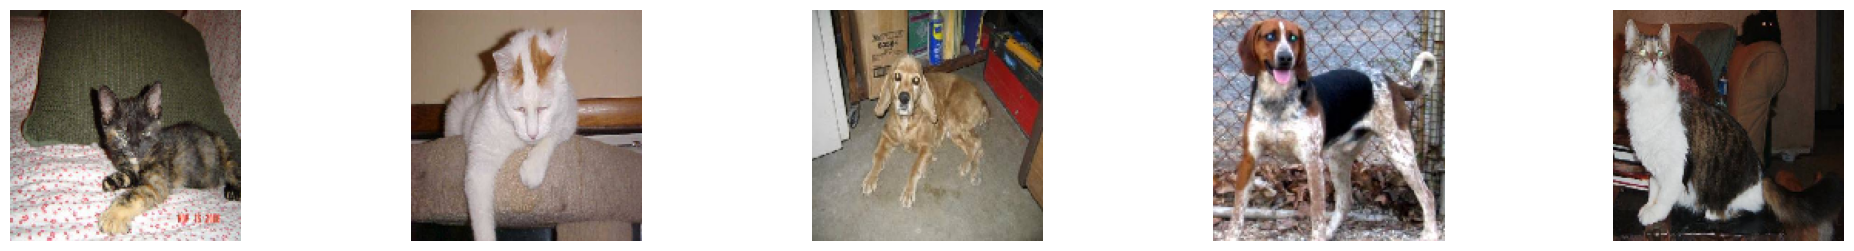

In [ ]:
def plotImages(images_arr, probabilities=False):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(5*len(images_arr), 3))
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for ax, img in zip(axes, images_arr):
        ax.imshow(img); ax.axis('off')
    plt.show()

# quick peek (optional)
batch_imgs = next(train_data_gen)[0][:5]
plotImages(batch_imgs)

Found 2000 images belonging to 2 classes.


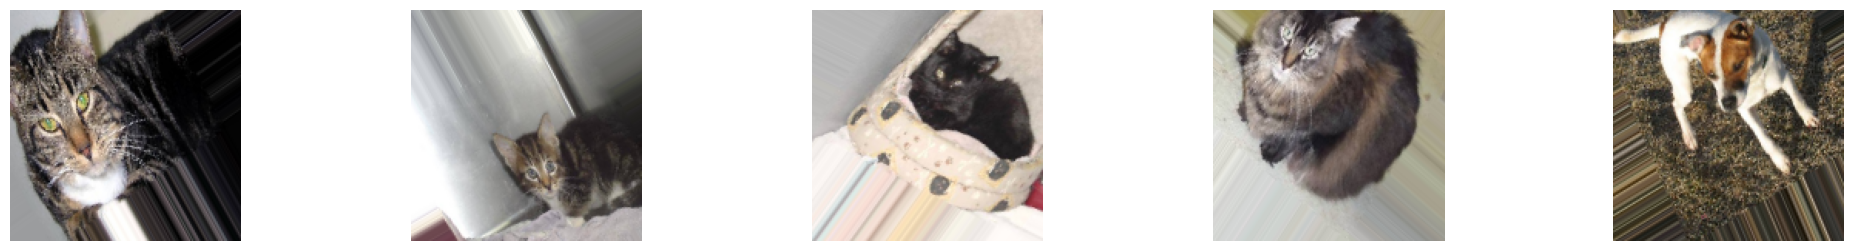

In [ ]:
aug_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = aug_train_gen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# optional: show 5 augmented images
aug_imgs = next(train_data_gen)[0][:5]
plotImages(aug_imgs)

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10  # increase to 12-15 if you want extra accuracy

history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    epochs=epochs
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6508 - loss: 0.6109 - val_accuracy: 0.7010 - val_loss: 0.5760
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6813 - loss: 0.6081 - val_accuracy: 0.6760 - val_loss: 0.5911
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6600 - loss: 0.6129 - val_accuracy: 0.6410 - val_loss: 0.6373
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6654 - loss: 0.6125 - val_accuracy: 0.6980 - val_loss: 0.5880
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6744 - loss: 0.6089 - val_accuracy: 0.7140 - val_loss: 0.5554
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.6974 - loss: 0.5676 - val_accuracy: 0.6920 - val_loss: 0.5757
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.6828 - loss: 0.5918 - val_accuracy: 0.7200 - val_loss: 0.5519
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7076 - loss: 0.5747 - val_accuracy: 0.7050 - v

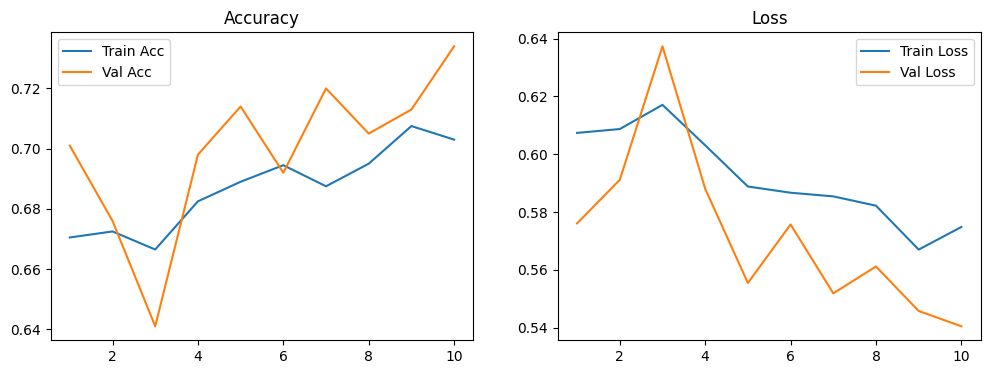

In [ ]:
acc     = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss    = history.history['loss']
val_loss= history.history['val_loss']
epochs_range = range(1, len(acc)+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

In [ ]:
# Probability of "dog" for each test image (shape: (50,))
probs = model.predict(test_data_gen).squeeze()
probabilities = probs.tolist()

print("first 10 probabilities:", probabilities[:10])
print("count:", len(probabilities))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
first 10 probabilities: [0.2979893088340759, 0.41516974568367004, 0.6925795078277588, 0.0470614917576313, 0.2787523865699768, 0.11290434002876282, 0.5643424987792969, 0.3125060200691223, 0.15869413316249847, 0.3673906624317169]
count: 50


In [ ]:
answers = [
 [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
  0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
  1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
  1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
  1, 0, 0, 0, 0, 0, 0, 0, 0],
]

correct = 0
for probability, answer in zip(probabilities, answers[0]):
    if round(probability) == answer:
        correct += 1

percentage_identified = (correct / len(answers[0])) * 100
passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")
if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying.")

Your model correctly identified 54.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying.
